## Assignment II: Random Forest

#### Step 1.Load libraries/ data

In [5]:
#Loading required libraries
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# import the required packages 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve,roc_auc_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split

import warnings
warnings.filterwarnings("ignore")

C:\Users\Sija\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# Load data
train_df = pd.read_csv("C:/Users/Sija/Downloads/titanic_train.csv") 
test_df = pd.read_csv("C:/Users/Sija/Downloads/titanic_test.csv") 

### Train Data

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have many columns (Sex, Embarked, Cabin) that needs encoding, before feeding it to the algorithm. The data in some columns (like ticket) 
have diffrent formats. 

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The average of people survived id 38%. This might be directly related to their age, 
class/deck they were in and also their gender.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are 891 records with 11 features and 1 target (Survived). There are missing values in Age, Cabin, Embarked features. For age, we can fill the missing rows with the mean age. Cabin column has only 204 rows with data, so it may be better to discard the row. As for Embarked, there is only 2 values missing, populating it with the mst common embarkment point may work.

In [9]:
train_df['Age'].fillna(train_df.Age.mean(), inplace = True)
train_df.drop(['Cabin','Ticket'], axis=1, inplace=True)
train_df['Embarked'].fillna('S', inplace = True)

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [9]:
train_df['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [10]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Only 342 people out of 891 survived  the accident, which is about 40%. Looking at the survival rate based on different features 
will give a better understanding of the survival pattern

In [11]:
train_df.groupby('Sex')['PassengerId'].count()

Sex
female    314
male      577
Name: PassengerId, dtype: int64

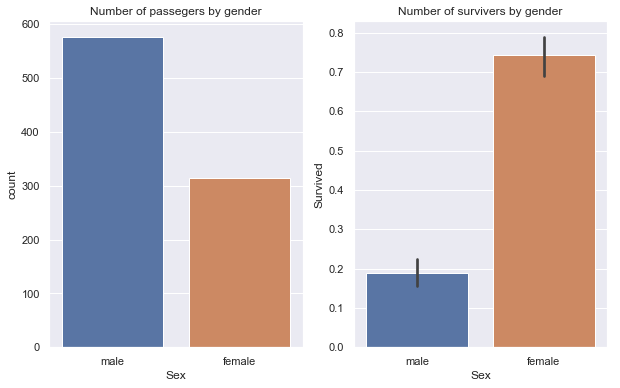

In [12]:
#Gender
fx, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title("Number of passegers by gender")
axes[1].set_title("Number of survivers by gender")
fig1 = sns.countplot(data=train_df, x='Sex', ax=axes[0])
fig2 = sns.barplot(data=train_df, x='Sex',y='Survived', ax=axes[1])

There were 577 males and 314 females passengers out of which 72% females and about 19% male survived the accident. 
This is because ladies and children were rescued first.

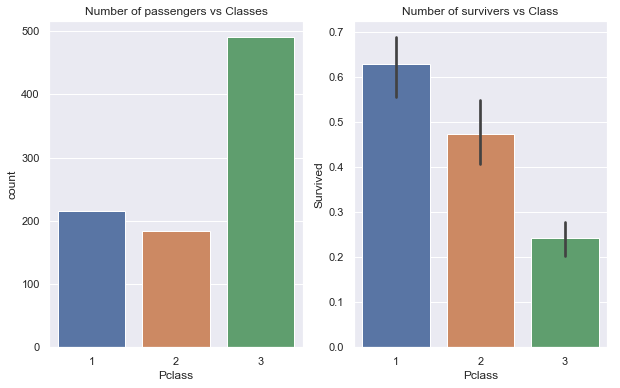

In [13]:
#Class
fx, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title("Number of passengers vs Classes")
axes[1].set_title("Number of survivers vs Class")
fig1 = sns.countplot(data=train_df, x='Pclass', ax=axes[0])
fig2 = sns.barplot(data=train_df, x='Pclass',y='Survived', ax=axes[1])

The number of passengers were higher in 3rd class followed by 1st and 2nd. However the survival rate was highest in 1st, then 2nd and finally 3rd. Again this is because eople from the higher classes were rescued first. It could also be because higher classes are usualy on the upper levels of the ship.

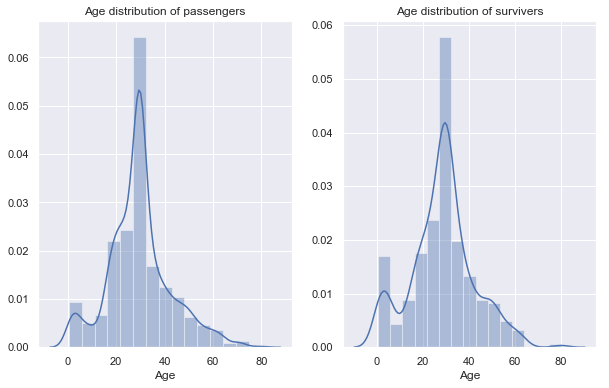

In [14]:
#Age
fx, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title("Age distribution of passengers")
axes[1].set_title("Age distribution of survivers")
fig1 = sns.distplot(train_df['Age'], bins=15, ax=axes[0])
fig2 = sns.distplot(train_df[train_df.Survived == 1].Age, bins=15, ax=axes[1])


Most of the passengers on board were between the age of 25-30 years. 

In [10]:
#Splitting age in to bins to change to categorical data
train_df['AgeBin'] = pd.cut(train_df['Age'].astype(int), 5)

In [11]:
train_df.AgeBin.value_counts().sort_values(ascending=True)

(64.0, 80.0]      11
(48.0, 64.0]      69
(-0.08, 16.0]    100
(32.0, 48.0]     186
(16.0, 32.0]     525
Name: AgeBin, dtype: int64

In [12]:
#Splitting Fare in to bins
train_df['FareBin'] = pd.qcut(train_df['Fare'], 3)
pd.qcut(train_df['Fare'], 3).value_counts()

(-0.001, 8.662]    308
(26.0, 512.329]    295
(8.662, 26.0]      288
Name: Fare, dtype: int64

In [13]:
#Creating a column for number of family members
train_df['Family'] =  train_df.Parch + train_df.SibSp
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBin,FareBin,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,"(16.0, 32.0]","(-0.001, 8.662]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,"(32.0, 48.0]","(26.0, 512.329]",1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,"(16.0, 32.0]","(-0.001, 8.662]",0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,"(32.0, 48.0]","(26.0, 512.329]",1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,"(32.0, 48.0]","(-0.001, 8.662]",0


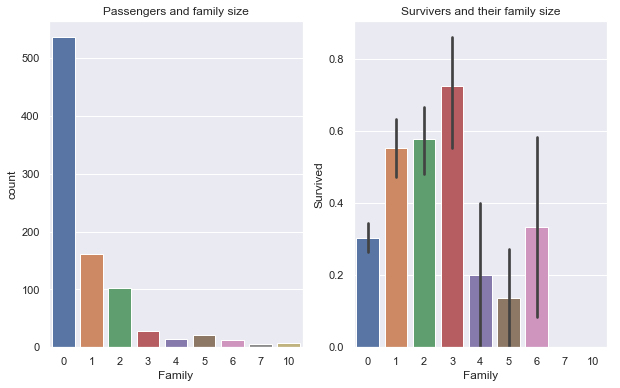

In [14]:
#Family
fx, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title("Passengers and family size")
axes[1].set_title("Survivers and their family size")
fig1 = sns.countplot(data=train_df, x='Family', ax=axes[0])
fig2 = sns.barplot(data=train_df, x='Family',y='Survived', ax=axes[1])

More than 500 passengers were travelling alone without any parents, children, spouse and siblings. The surviver rate is very high for passengers with family of size 3,2 and 1 respectively. That is, if a passenger had family onboard, the chance of survival was high. Again this is probably because the women and children were recued first. 

### Test Data

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [16]:
test_df['Age'].fillna(test_df.Age.mean(), inplace = True)
test_df.drop(['Cabin','Ticket'], axis=1, inplace=True)
test_df['Fare'].fillna(test_df.Fare.mean(), inplace = True)

#Splitting age in to bins to change to categorical data
test_df['AgeBin'] = pd.cut(test_df['Age'].astype(int), 5)
test_df['FareBin'] = pd.qcut(test_df['Fare'], 3)

#Creating a column for number of family members
test_df['Family'] =  test_df.Parch + test_df.SibSp

In [17]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBin,FareBin,Family
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,"(30.4, 45.6]","(-0.001, 8.662]",0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,"(45.6, 60.8]","(-0.001, 8.662]",1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,"(60.8, 76.0]","(8.662, 26.0]",0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,"(15.2, 30.4]","(-0.001, 8.662]",0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,"(15.2, 30.4]","(8.662, 26.0]",2


In [18]:
print(train_df.columns.values)
print(test_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Fare' 'Embarked' 'AgeBin' 'FareBin' 'Family']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare'
 'Embarked' 'AgeBin' 'FareBin' 'Family']


### Encoding

In [20]:
#Label encoding
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])  #Sex column
train_df['Embarked'] = le.fit_transform(train_df['Embarked'])  #Embarked column
train_df['AgeBin'] = le.fit_transform(train_df['AgeBin'])  #Age bin
train_df['FareBin'] = le.fit_transform(train_df['FareBin'])  #Fare bin


test_df['Sex'] = le.fit_transform(test_df['Sex'])  #Sex column
test_df['Embarked'] = le.fit_transform(test_df['Embarked'])  #Embarked column
test_df['AgeBin'] = le.fit_transform(test_df['AgeBin'])  #Age bin
test_df['FareBin'] = le.fit_transform(test_df['FareBin'])  #FareBin

In [21]:
train_features = train_df.drop(['PassengerId','Name','Age','SibSp','Parch','Fare','Survived'],axis=1)
train_target = train_df['Survived']

test_features = test_df.drop(['PassengerId','Name','Age','SibSp','Parch','Fare'],axis=1)
train_features.head()

,Pclass,Sex,Embarked,AgeBin,FareBin,Family
0,3,1,2,1,0,1
1,1,0,0,2,2,1
2,3,0,2,1,0,0
3,1,0,2,2,2,1
4,3,1,2,2,0,0


In [22]:
#Taking only relevant features into consideration
X = train_features.values
X_test_new = test_features.values

y = train_target.values

In [23]:
#One Hot Encoding
ohe = OneHotEncoder()
X_enc = ohe.fit_transform(X).toarray()  
X_test_new_enc = ohe.fit_transform(test_features).toarray()
print(X_enc.shape, X_test_new_enc.shape)

(891, 25) (418, 25)


In [24]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=.25, random_state=42)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(668, 25) (223, 25) (668,) (223,)


In [79]:
# Feature scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)
X_std = sc.fit_transform(X_enc)
X_test_new_std =  sc.fit_transform(X_test_new_enc)

In [26]:
X_train_std.shape

(668, 25)

In [27]:
# Fitting classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, oob_score=True, criterion = 'entropy')
rf.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [28]:
#RF score
rf_score = round(rf.score(X_train_std, y_train) * 100, 2)
print("The training accuracy score is: ", round(rf_score,2,), "%")

#Score of training dataset using oob estimate
print("Out of bag score of training set is : ", rf.oob_score_*100, "%")

The training accuracy score is:  86.68 %
Out of bag score of training set is :  79.19161676646706 %


The training accuracy of 86% looks pretty good. The OOB estimate gives 79%, this is more close to the the test data and gives more accurate value of accuracy for a training set

In [29]:
#Cross validation 
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train_std, y_train, scoring='accuracy' ,cv=10)   
print("Scores for 10 fold validation :", scores)
print("The mean training accuracy with 10 fold cross validation is %s" % round(scores.mean()*100,2), "%")

Scores for 10 fold validation : [0.76470588 0.70588235 0.85294118 0.8358209  0.7761194  0.72727273
 0.75757576 0.75757576 0.8030303  0.87878788]
The mean training accuracy with 10 fold cross validation is 78.6 %


#### AUC score

In [30]:
from sklearn.metrics import roc_auc_score

# getting the probabilities of our predictions
y_scores_tr = rf.predict_proba(X_train_std)[:,1]
r_a_score_tr = roc_auc_score(y_train, y_scores_tr)
print("ROC-AUC-Score(train):", r_a_score_tr)

y_scores_ts = rf.predict_proba(X_test_std)[:,1]
r_a_score_ts = roc_auc_score(y_test, y_scores_ts)
print("ROC-AUC-Score(test):", r_a_score_ts)

ROC-AUC-Score(train): 0.9338111338635172
ROC-AUC-Score(test): 0.8620660741237631


#### ROC plot

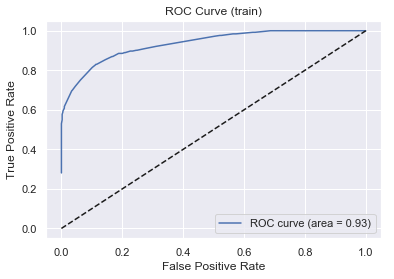

In [31]:
from sklearn.metrics import roc_curve, auc
# Determine the false positive and true positive rates
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_scores_tr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr_tr, tpr_tr, label='ROC curve (area = %0.2f)' % r_a_score_tr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (train)')
plt.legend(loc="lower right")
plt.show()

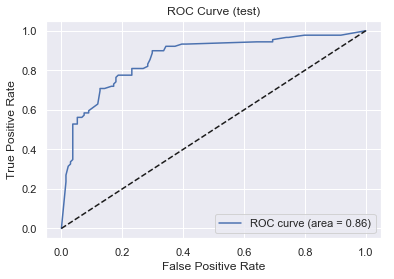

In [32]:
# Determine the false positive and true positive rates
fpr_ts, tpr_ts, _ = roc_curve(y_test, y_scores_ts)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr_ts, tpr_ts, label='ROC curve (area = %0.2f)' % r_a_score_ts)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (test)')
plt.legend(loc="lower right")
plt.show()

The AUC is higher for train set.

### Tuning parameter

#### n_estimaters

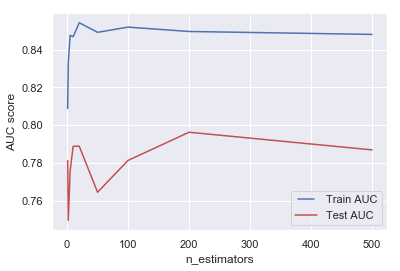

In [63]:
#Trying the model with different values of n_estimators

n_estimators = [1, 2, 5, 10, 20, 50, 100, 200, 500]

train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_std, y_train)
    train_pred = rf.predict(X_train_std)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test_std)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

N_estimator of 200 trees is giving the highest AUC score in test dataset, then adding more trees decreases the AUC score. For the training set, we can see AUC is the highest for 50 trees, and then it falls until it becomes pretty constant after 100 trees.

####  max_depth

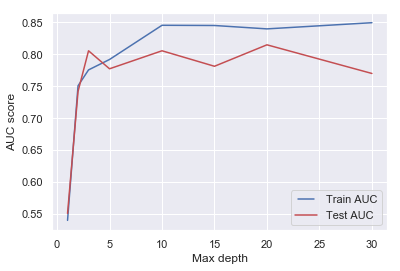

In [41]:
max_depths = [1,2,3,5,10,15,20,30]

train_results = []
test_results = []
for depth in max_depths:
    rf = RandomForestClassifier(max_depth=depth, n_jobs=-1)
    rf.fit(X_train_std, y_train)
    
    y_pred_train = rf.predict(X_train_std)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    
    y_pred_test = rf.predict(X_test_std)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Max depth')
plt.show()

Increasing max_depth beyond a point leads to overfitting of test set. A value of 3 gives 80% AUC. The train data shows steady 
increase in performance with increasing depth, and remains constant after depth of 10, possibly because it is fully trained.

#### min_samples _split


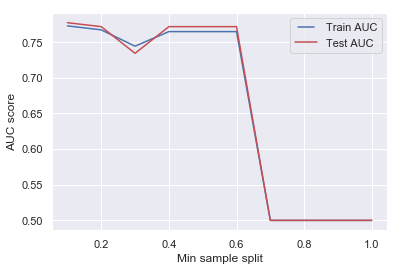

In [42]:
#min_samples _split values between 10% to 100%
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []
for samples in min_samples_split:
    rf = RandomForestClassifier(min_samples_split=samples, n_jobs=-1)
    rf.fit(X_train_std, y_train)
    
    y_pred_train = rf.predict(X_train_std)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    
    y_pred_test = rf.predict(X_test_std)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_split, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_split, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Min sample split')
plt.show()

Increasing min_sample_split is decreasing the AUC score and leading to underfiting. Low value of 0.1 is optimal

####  min__samples _leaf

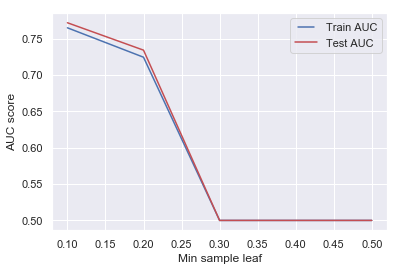

In [43]:
#min_samples_leaf values between 10% to 50%
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []
for leafs in min_samples_leaf:
    rf = RandomForestClassifier(min_samples_leaf=leafs, n_jobs=-1)
    rf.fit(X_train_std, y_train)
    
    y_pred_train = rf.predict(X_train_std)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    
    y_pred_test = rf.predict(X_test_std)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leaf, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leaf, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Min sample leaf')
plt.show()

Increasing the sample leaf is drastically reducing the AUC for both train and test sets, thus leading to underfitting. 
The value of 0.1 is giving the best performance in the range considered 

#### max_features

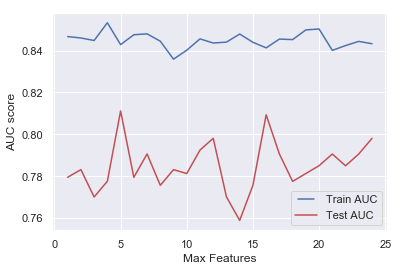

In [45]:
#max_features varied between 1 and total number of features in the dataset
max_features = list(range(1,X_train_std.shape[1]))

train_results = []
test_results = []
for feature in max_features:
    rf = RandomForestClassifier(max_features=feature, n_jobs=-1)
    rf.fit(X_train_std, y_train)
    
    y_pred_train = rf.predict(X_train_std)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    
    y_pred_test = rf.predict(X_test_std)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Max Features')
plt.show()

Looks like increasing max_feature is resulting in overfiting on bih train and test set

#### Putting ALL together

In [53]:
#The Gridsearch can be used to find the best parameters using just one block of code

#Gridsearch on train set

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=-1)
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [0.1, 0.2, 0.3, 0.4, 0.5], \
              "max_depth" : [1,2,3,5,10,15,20,30],\
              "min_samples_split" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],\
              "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],"max_features": ['sqrt', 'auto', 'log2'],}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

print("The best score is: ", gs.best_score_)
print("The best parameters are: ",gs.best_params_)

The best score is:  0.7979041916167665
The best parameters are:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 50}


The model gives a score of 79.79% on the training set, which is slightly higher than the score on the cross validation step.
The best parameters given by Gridsearch does match the parameters obtained from the individual tunings (for eg: n_estimator of 50, 
max_depth of 2, min_samples_leaf of 10%)

In [55]:
#The Gridsearch can be used to find the best parameters using just one block of code
#Gridsearch on test data

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=-1)
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [0.1, 0.2, 0.3, 0.4, 0.5], \
              "max_depth" : [1,2,3,5,10,15,20,30],\
              "min_samples_split" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],\
              "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],"max_features": ['sqrt', 'auto', 'log2'],}

gs1 = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gs1 = gs1.fit(X_test_std, y_test)

print("The best score is: ", gs1.best_score_)
print("The best parameters are: ",gs1.best_params_)

The best score is:  0.7937219730941704
The best parameters are:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10}


The best score on the test data is slightly lower than the training model, however close to the OOB score obtained earlier. The are deviations in the best parameters as well as compared to their indiviual AUC analysis. Best n_estimator value given by the Gridseach model is 10, while the AUC was highest for 200 trees. It s clear that the model performs better with lower values of min_samples_leaf and min_samples_split.

#### Using the tuned model on the new X_test data to predict the survivals

In [67]:
#Defining classifier with the best parameters
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=50,
                             min_samples_split=0.1,
                             min_samples_leaf=0.1,
                             max_depth = 2,
                             max_features='log2',
                             oob_score=True,
                             random_state=42,
                             n_jobs=-1)

#Fitting the model on the entire dataset
rf.fit(X_std, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [83]:
print("The score of the new model is : " , rf.score(X_std, y))

The score of the new model is :  0.7912457912457912


In [80]:
#Introduce the new test set t the model to predict survival  
predictions = rf.predict(X_test_new_std)

In [82]:
#Predictions
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,